In [43]:
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F
from torch import nn
from torch.cuda import is_available
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from utils import viewPlots

In [44]:
device = torch.device("cuda" if is_available() else "cpu")
device

device(type='cuda')

In [45]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1325,), (0.3105,))]
)

In [46]:
training_data = datasets.MNIST('./data',train=True,download=True,transform=train_transforms)
testing_data = datasets.MNIST('./data',train=False,download=True,transform=test_transforms)

In [47]:
kwargs = {'batch_size': 64, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(training_data, **kwargs)
kwargs = {'batch_size': 128, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(testing_data, **kwargs)
val_loader = torch.utils.data.DataLoader(testing_data, **kwargs)


batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])
batch_data[i]:  torch.Size([1, 28, 28])


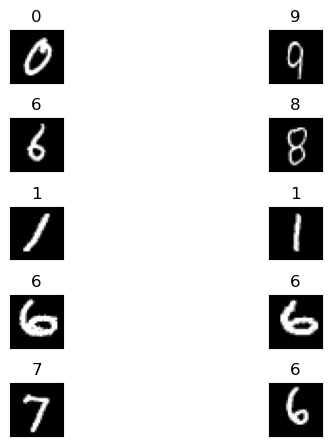

In [48]:
batch_data, batch_label = next(iter(train_loader))
viewPlots(batch_data,batch_label,10)

In [49]:

class MNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128,
        kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.tns1 = nn.Conv2d(in_channels=128, out_channels=4,
        kernel_size=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16,
        kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16,
        kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=16)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32,
        kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=32)
       
        self.pool2 = nn.MaxPool2d(2, 2)
        self.tns2 = nn.Conv2d(in_channels=32, out_channels=16,
        kernel_size=1)
        
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=20,
        kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=20)
        self.conv6 = nn.Conv2d(in_channels=20, out_channels=32,
        kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(num_features=32)
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=10,
        kernel_size=1)
        self.gpool = nn.AvgPool2d(kernel_size=7)
        self.drop = nn.Dropout2d(0.2)


    
    def forward(self,x):
        x = self.tns1(self.drop(self.bn1(F.relu(self.conv1(x))))) 
        x = self.drop(self.bn2(F.relu(self.conv2(x))))
        x = self.pool1(x)
        x = self.drop(self.bn3(F.relu(self.conv3(x))))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.tns2(self.pool2(x))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.bn6(F.relu(self.conv6(x)))
        x = self.conv7(x)
        x = self.gpool(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)


In [50]:
model = MNet().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 26, 26]           1,280
       BatchNorm2d-2          [-1, 128, 26, 26]             256
         Dropout2d-3          [-1, 128, 26, 26]               0
            Conv2d-4            [-1, 4, 28, 28]             516
            Conv2d-5           [-1, 16, 28, 28]             592
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         Dropout2d-7           [-1, 16, 28, 28]               0
         MaxPool2d-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
      BatchNorm2d-10           [-1, 16, 14, 14]              32
        Dropout2d-11           [-1, 16, 14, 14]               0
           Conv2d-12           [-1, 32, 14, 14]           4,640
      BatchNorm2d-13           [-1, 32, 14, 14]              64
        MaxPool2d-14             [-1, 3

C:\Users\maitr\AppData\Local\Temp\ipykernel_16800\1454515601.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [51]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'epoch: {epoch} loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target,
                reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct +=pred.eq(target.view_as(pred)).sum().item()
            test_loss /= len(test_loader.dataset)
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(test_loss, correct,len(test_loader.dataset), 100. * correct /len(test_loader.dataset)))

In [52]:
model = MNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.015,momentum=0.9)
for epoch in range(1, 21):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, val_loader)

  0%|          | 0/938 [00:00<?, ?it/s]C:\Users\maitr\AppData\Local\Temp\ipykernel_16800\1454515601.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
epoch: 1 loss=0.090191550552845 batch_id=937: 100%|██████████| 938/938 [00:10<00:00, 87.31it/s]    



Validation set: Average loss: 0.0001, Accuracy: 9812/10000 (98.1%)



epoch: 2 loss=0.1046583354473114 batch_id=937: 100%|██████████| 938/938 [00:10<00:00, 88.98it/s]   



Validation set: Average loss: 0.0001, Accuracy: 9875/10000 (98.8%)



epoch: 3 loss=0.01603892259299755 batch_id=937: 100%|██████████| 938/938 [00:10<00:00, 88.90it/s]   



Validation set: Average loss: 0.0003, Accuracy: 9883/10000 (98.8%)



epoch: 4 loss=0.015566268935799599 batch_id=937: 100%|██████████| 938/938 [00:10<00:00, 88.32it/s]  



Validation set: Average loss: 0.0000, Accuracy: 9893/10000 (98.9%)



epoch: 5 loss=0.006707039661705494 batch_id=937: 100%|██████████| 938/938 [00:10<00:00, 87.50it/s]  



Validation set: Average loss: 0.0000, Accuracy: 9926/10000 (99.3%)



epoch: 6 loss=0.08851692825555801 batch_id=937: 100%|██████████| 938/938 [00:11<00:00, 82.30it/s]   



Validation set: Average loss: 0.0000, Accuracy: 9934/10000 (99.3%)



epoch: 7 loss=0.1549907773733139 batch_id=937: 100%|██████████| 938/938 [00:10<00:00, 86.60it/s]    



Validation set: Average loss: 0.0003, Accuracy: 9913/10000 (99.1%)



epoch: 8 loss=0.011836744844913483 batch_id=937: 100%|██████████| 938/938 [00:10<00:00, 86.18it/s]  



Validation set: Average loss: 0.0000, Accuracy: 9931/10000 (99.3%)



epoch: 9 loss=0.01092913094907999 batch_id=937: 100%|██████████| 938/938 [00:10<00:00, 86.25it/s]   



Validation set: Average loss: 0.0001, Accuracy: 9922/10000 (99.2%)



epoch: 10 loss=0.0012779455864802003 batch_id=937: 100%|██████████| 938/938 [00:11<00:00, 84.59it/s] 



Validation set: Average loss: 0.0000, Accuracy: 9920/10000 (99.2%)



epoch: 11 loss=0.014655736275017262 batch_id=937: 100%|██████████| 938/938 [00:10<00:00, 85.61it/s]  



Validation set: Average loss: 0.0000, Accuracy: 9941/10000 (99.4%)



epoch: 12 loss=0.0026219752617180347 batch_id=937: 100%|██████████| 938/938 [00:10<00:00, 85.66it/s] 



Validation set: Average loss: 0.0000, Accuracy: 9931/10000 (99.3%)



epoch: 13 loss=0.017978549003601074 batch_id=937: 100%|██████████| 938/938 [00:11<00:00, 84.57it/s]  



Validation set: Average loss: 0.0000, Accuracy: 9939/10000 (99.4%)



epoch: 14 loss=0.010321687906980515 batch_id=937: 100%|██████████| 938/938 [00:11<00:00, 83.80it/s]  



Validation set: Average loss: 0.0000, Accuracy: 9941/10000 (99.4%)



epoch: 15 loss=0.025719312950968742 batch_id=937: 100%|██████████| 938/938 [00:11<00:00, 83.14it/s]  



Validation set: Average loss: 0.0000, Accuracy: 9940/10000 (99.4%)



epoch: 16 loss=0.004029408562928438 batch_id=937: 100%|██████████| 938/938 [00:11<00:00, 83.98it/s]   



Validation set: Average loss: 0.0000, Accuracy: 9946/10000 (99.5%)



epoch: 17 loss=0.02120126411318779 batch_id=937: 100%|██████████| 938/938 [00:11<00:00, 84.07it/s]   



Validation set: Average loss: 0.0000, Accuracy: 9930/10000 (99.3%)



epoch: 18 loss=0.003304046578705311 batch_id=937: 100%|██████████| 938/938 [00:11<00:00, 82.73it/s]  



Validation set: Average loss: 0.0000, Accuracy: 9941/10000 (99.4%)



epoch: 19 loss=0.01329675130546093 batch_id=937: 100%|██████████| 938/938 [00:11<00:00, 83.23it/s]   



Validation set: Average loss: 0.0000, Accuracy: 9946/10000 (99.5%)



epoch: 20 loss=0.01769583486020565 batch_id=937: 100%|██████████| 938/938 [00:10<00:00, 85.63it/s]   



Validation set: Average loss: 0.0000, Accuracy: 9939/10000 (99.4%)

